## Set up the SNPE SDK v2.30.0

In [3]:
import os
print(os.environ['SNPE_ROOT'])

/home/likhiths/v2.30.0.250109/qairt/2.30.0.250109


## Setting up the Environmet

In [24]:
!source $SNPE_ROOT/bin/envsetup.sh

[INFO] AISW SDK environment set
[INFO] QNN_SDK_ROOT: /home/likhiths/v2.30.0.250109/qairt/2.30.0.250109
[INFO] SNPE_ROOT: /home/likhiths/v2.30.0.250109/qairt/2.30.0.250109


In [25]:
!source /home/likhiths/PYTHON3.10_VENV_ROOT/bin/activate

In [6]:
# Install Ultralytics if not already installed
! pip install ultralytics

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 2.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.14.0
    Uninstalling sympy-1.14.0:
      Successfully uninstalled sympy-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
onnxslim 0.1.59 requires sympy>=1.13.3, but you have sympy 1.13.1 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## Preparing the Raw file

In [2]:
import cv2
import numpy as np

img = cv2.imread("airplane.jpg")           # Replace with your image file 
img = cv2.resize(img, (640, 640))                    
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img = img/255       
img = img.astype(np.float32)                       
img.tofile("airplane.raw")                            

## Push the raw data to the target device

In [ ]:
!adb push airplane.jpg /data/local/tmp/segmentation
!adb push airplane.raw /data/local/tmp/segmentation

airplane.raw: 1 file pushed. 21.8 MB/s (4915200 bytes in 0.215s)


## Prepare the input list text file with path to the raw files

In [14]:
!adb push input_list.txt /data/local/tmp/segmentation

input_list.txt: 1 file pushed. 0.0 MB/s (12 bytes in 0.006s)


## Setting up the target device environment (snapdragon 695)

In [6]:
!export SNPE_TARGET_ARCH=aarch64-android
!export SNPE_TARGET_DSPARCH=hexagon-v73

!adb shell "mkdir -p /data/local/tmp/snpeexample/$SNPE_TARGET_ARCH/bin"
!adb shell "mkdir -p /data/local/tmp/snpeexample/$SNPE_TARGET_ARCH/lib"
!adb shell "mkdir -p /data/local/tmp/snpeexample/dsp/lib"

!adb push $SNPE_ROOT/lib/$SNPE_TARGET_ARCH/*.so /data/local/tmp/snpeexample/$SNPE_TARGET_ARCH/lib
!adb push $SNPE_ROOT/lib/$SNPE_TARGET_DSPARCH/unsigned/*.so data/local/tmp/snpeexample/dsp/lib
!adb push $SNPE_ROOT/bin/$SNPE_TARGET_ARCH/snpe-net-run /data/local/tmp/snpeexample/$SNPE_TARGET_ARCH/bin

/home/likhiths/v2.30.0.250109/qairt/2....ushed. 0.2 MB/s (5832 bytes in 0.022s)
/home/likhiths/v2.30.0.250109/qairt/2....d. 23.6 MB/s (6170328 bytes in 0.250s)
/home/likhiths/v2.30.0.250109/qairt/2....d. 23.1 MB/s (2399336 bytes in 0.099s)
/home/likhiths/v2.30.0.250109/qairt/2....d. 21.8 MB/s (2399336 bytes in 0.105s)
/home/likhiths/v2.30.0.250109/qairt/2..... 24.8 MB/s (12205984 bytes in 0.469s)
/home/likhiths/v2.30.0.250109/qairt/2....ed. 19.2 MB/s (590312 bytes in 0.029s)
/home/likhiths/v2.30.0.250109/qairt/2....d. 24.5 MB/s (5634320 bytes in 0.219s)
/home/likhiths/v2.30.0.250109/qairt/2....ed. 15.9 MB/s (423200 bytes in 0.025s)
/home/likhiths/v2.30.0.250109/qairt/2....d. 22.1 MB/s (1405008 bytes in 0.061s)
/home/likhiths/v2.30.0.250109/qairt/2....ushed. 0.6 MB/s (5832 bytes in 0.010s)
/home/likhiths/v2.30.0.250109/qairt/2....ed. 17.9 MB/s (312912 bytes in 0.017s)
/home/likhiths/v2.30.0.250109/qairt/2....ed. 21.1 MB/s (849936 bytes in 0.038s)
/home/likhiths/v2.30.0.250109/qairt/2...

In [7]:
!adb shell "export SNPE_TARGET_ARCH=aarch64-android && \
export LD_LIBRARY_PATH=\$LD_LIBRARY_PATH:/data/local/tmp/snpeexample/\$SNPE_TARGET_ARCH/lib && \
export PATH=\$PATH:/data/local/tmp/snpeexample/\$SNPE_TARGET_ARCH/bin && \
snpe-net-run -h"

Command Line Options:
  [ -h, --help ]        Displays this help message.
  [ --version ]         Displays version information.
  --container=<val>     Path to the DL container containing the network.
  --input_list=<val>    Path to a file listing the inputs for the network.
                        Optionally the file can have "#" starting line to specify the layer names or "%" to specify the output tensor
                        names for which output tensor files are to be produced. For more details about the input_list file format,
                        please refer to SDK html documentation (docs/general/tools.html#snpe-net-run input_list argument)
  [ --use_gpu ]         Use the GPU runtime for SNPE. Default float32 math and float16 storage.
  [ --use_dsp ]         Use the DSP fixed point runtime for SNPE. Data & Math: 8bit fixed point Tensorflow style format.
  [ --use_aip ]         Use the AIP fixed point runtime for SNPE. Data & Math: 8bit fixed point Tensorflow style format.

## Getting the ONNX Model

In [26]:
os.makedirs('models', exist_ok=True)

In [37]:
from ultralytics import YOLO
model = YOLO('models/yolov8n-seg.pt')

model.export(
    format="onnx",
    imgsz=(640, 640),
    dynamic=False,
    opset=11,
    simplify=True,
    half=False,
    nms=False,
    batch=1,
    device='cpu'
)

Ultralytics 8.3.105 🚀 Python-3.10.12 torch-2.6.0+cu124 CPU (12th Gen Intel Core(TM) i5-1235U)
YOLOv8n-seg summary (fused): 85 layers, 3,404,320 parameters, 0 gradients, 12.6 GFLOPs

PyTorch: starting from 'models/yolov8n-seg.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 116, 8400), (1, 32, 160, 160)) (6.7 MB)

ONNX: starting export with onnx 1.13.0 opset 11...
ONNX: slimming with onnxslim 0.1.59...
ONNX: simplifier failure: FLOAT8E4M3FN
ONNX: export success ✅ 0.5s, saved as 'models/yolov8n-seg.onnx' (13.2 MB)

Export complete (1.0s)
Results saved to /home/likhiths/Mini-Project/InstaceSeg-Yolov8/models
Predict:         yolo predict task=segment model=models/yolov8n-seg.onnx imgsz=640  
Validate:        yolo val task=segment model=models/yolov8n-seg.onnx imgsz=640 data=coco.yaml  
Visualize:       https://netron.app


'models/yolov8n-seg.onnx'

In [38]:
import onnx

model = onnx.load("models/yolov8n-seg.onnx")
for output in model.graph.output:
    print(output.name)

output0
output1


In [39]:
%%bash
source $SNPE_ROOT/bin/envsetup.sh && \

snpe-onnx-to-dlc \
    --input_network models/yolov8n-seg.onnx \
    --out_name output0 \
    --out_name output1 \
    --output_path yolov8n-seg.dlc

[INFO] AISW SDK environment set
[INFO] QNN_SDK_ROOT: /home/likhiths/v2.30.0.250109/qairt/2.30.0.250109
[INFO] SNPE_ROOT: /home/likhiths/v2.30.0.250109/qairt/2.30.0.250109


2025-07-14 20:35:08,168 - 245 - INFO - Input shape info 
2025-07-14 20:35:10,237 - 245 - INFO - user_provided_output is same as graph_output..skipping update_output_names call
2025-07-14 20:35:10,704 - 245 - INFO - INFO_INITIALIZATION_SUCCESS: 
2025-07-14 20:35:10,790 - 245 - INFO - INFO_CONVERSION_SUCCESS: Conversion completed successfully
2025-07-14 20:35:10,820 - 245 - INFO - INFO_WRITE_SUCCESS: 


In [40]:
import onnx

model = onnx.load("models/yolov8n-seg.onnx")
for input_tensor in model.graph.input:
    print("Input name:", input_tensor.name)
    print("Shape:")
    for dim in input_tensor.type.tensor_type.shape.dim:
        print(" ", dim.dim_value if dim.dim_value else "dynamic")


Input name: images
Shape:
  1
  3
  640
  640


## Visualize the DLC

In [41]:
%%bash
source $SNPE_ROOT/bin/envsetup.sh
snpe-dlc-info -i models/yolov8n-seg.dlc

[INFO] AISW SDK environment set
[INFO] QNN_SDK_ROOT: /home/likhiths/v2.30.0.250109/qairt/2.30.0.250109
[INFO] SNPE_ROOT: /home/likhiths/v2.30.0.250109/qairt/2.30.0.250109
DLC info of: /home/likhiths/Mini-Project/InstaceSeg-Yolov8/models/yolov8n-seg.dlc
                                                                                                    
Model Version: 
Model Copyright:
Converter command: snpe-onnx-to-dlc; unroll_gru_time_steps=True; quantization_overrides=; prepare_inputs_as_params=False; perform_axes_to_spatial_first_order=True; unroll_lstm_time_steps=True; packed_max_seq=1; validation_target=[]; packed_masked_softmax_inputs=[]; preserve_io=[]; debug=-1; dump_qairt_io_config_yaml=; multi_time_steps_lstm=False; multi_time_steps_gru=False; input_dtype=[]; keep_disconnected_nodes=False; input_encoding=[]; handle_gather_negative_indices=True; copyright_file=None; force_prune_cast_ops=False; perform_layout_transformation=False; keep_quant_nodes=False; package_name=None; inpu

In [23]:
%%bash
source $SNPE_ROOT/bin/envsetup.sh
snpe-dlc-info -i models/yolov8n-seg-quantized.dlc

[INFO] AISW SDK environment set
[INFO] QNN_SDK_ROOT: /home/likhiths/v2.30.0.250109/qairt/2.30.0.250109
[INFO] SNPE_ROOT: /home/likhiths/v2.30.0.250109/qairt/2.30.0.250109
DLC info of: /home/likhiths/Mini-Project/InstaceSeg-Yolov8/models/yolov8n-seg-quantized.dlc
                                                                                                    
Model Version: 
Model Copyright:
Converter command: snpe-onnx-to-dlc; converter_op_package_lib=; expand_lstm_op_structure=False; adjust_nms_features_dims=True; inject_cast_for_gather=True; define_symbol=None; squash_box_decoder=True; dump_inferred_model=False; apply_masked_softmax=uncompressed; input_dim=None; match_caffe_ssd_to_tf=True; custom_io=; dumpIR=False; no_simplification=False; dump_custom_io_config_template=; dump_value_info=False; expand_gru_op_structure=True; input_layout=[]; align_matmul_ranks=True; preprocess_roi_pool_inputs=True; custom_op_config_paths=None; enable_framework_trace=False; batch=None; keep_int64_in

## Quantize the DLC

In [33]:
%%bash
source $SNPE_ROOT/bin/envsetup.sh
snpe-dlc-quantize --input_dlc models/yolov8n-seg.dlc --input_list input.txt --output_dlc models/yolov8n-seg-quantized.dlc

[INFO] AISW SDK environment set
[INFO] QNN_SDK_ROOT: /home/likhiths/v2.30.0.250109/qairt/2.30.0.250109
[INFO] SNPE_ROOT: /home/likhiths/v2.30.0.250109/qairt/2.30.0.250109


[INFO] InitializeStderr: DebugLog initialized.
[INFO] Processed command-line arguments
[INFO] Quantized parameters
[INFO] Generated activations
[USER_INFO] Successfully saved DLC to /home/likhiths/Mini-Project/InstaceSeg-Yolov8/models/yolov8n-seg-quantized.dlc
[INFO] Saved quantized dlc to: models/yolov8n-seg-quantized.dlc
[INFO] DebugLog shutting down.


     0.1ms [  INFO ] Inferences will run in sync mode
     0.2ms [  INFO ] Initializing logging in the backend. Callback: [0x5b6d60ed55e0], Log Level: [3]
     0.2ms [  INFO ] No BackendExtensions lib provided;initializing NetRunBackend Interface
     0.3ms [  INFO ] [QNN_CPU] CpuBackend creation start
     0.3ms [  INFO ] [QNN_CPU] CpuBackend creation end
     0.5ms [WARNING] Unable to find a device with NetRunDeviceKeyDefault in Library NetRunBackendLibKeyDefault
     0.5ms [WARNING] Profile Logger with name = defaultKey doesn't exist! Returning nullptr
     0.4ms [  INFO ] [QNN_CPU] QnnContext create start
     0.4ms [  INFO ] [QNN_CPU] QnnContext create end
     1.1ms [  INFO ] Entering QuantizeRuntimeApp flow
     1.1ms [WARNING] Profile Logger with name = defaultKey doesn't exist! Returning nullptr
     1.0ms [  INFO ] [QNN_CPU] CpuGraph creation start
     1.0ms [  INFO ] [QNN_CPU] CpuGraph creation end
     1.0ms [  INFO ] [QNN_CPU] QnnGraph create end
    14.9ms [  INFO ] [QNN

## Push the models to the target device

In [ ]:
!adb push models/yolov8n-seg.dlc /data/local/tmp/segmentation
!adb push models/yolov8n-seg-quantized.dlc /data/local/tmp/segmentation

## Running the Inference on Target Device

In [17]:
!adb shell "export SNPE_TARGET_ARCH=aarch64-android && \
export LD_LIBRARY_PATH=/data/local/tmp/snpeexample/\$SNPE_TARGET_ARCH/lib && \
export PATH=/data/local/tmp/snpeexample/\$SNPE_TARGET_ARCH/bin:\$PATH && \
cd /data/local/tmp/segmentation && \
snpe-net-run --container yolov8n-seg.dlc \
--input_list input_list.txt \
--output_dir output \
--set_output_tensors='yolov8n-seg output0,output1'"

-------------------------------------------------------------------------------
Model String: N/A
SNPE v2.30.0.250109154455_113461
-------------------------------------------------------------------------------

Processing graph : yolov8n-seg
Processing DNN input(s):
airplane.raw
Successfully executed graph yolov8n-seg


## Getting the result back to device

In [18]:
!adb pull /data/local/tmp/segmentation/output/ ./results1/

/data/local/tmp/segmentation/output/: ...d. 17.5 MB/s (7228776 bytes in 0.393s)


In [22]:
import numpy as np

# Load the raw file
data = np.fromfile("results1/Result_0/output1.raw", dtype=np.float32)
data.shape

(819200,)

## Process the output tensors

Saved to ./segmentation_results.jpg


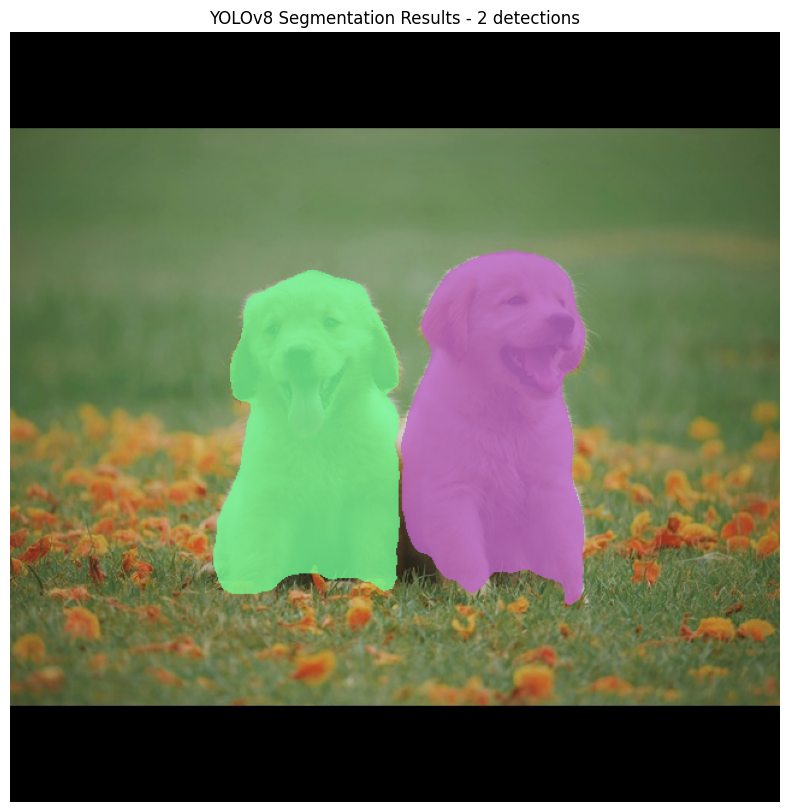


Detection Summary:
  1. dog: 0.743
  2. dog: 0.609


In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from typing import Tuple, Optional

class YOLOv8SegmentationPostProcessor:
    def __init__(self, 
                 conf_threshold: float = 0.5, 
                 nms_threshold: float = 0.4,
                 input_size: Tuple[int, int] = (640, 640)):
        self.conf_threshold = conf_threshold
        self.nms_threshold = nms_threshold
        self.input_size = input_size
        
        self.class_names = [
            'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
            'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
            'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
            'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
            'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
            'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
            'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
            'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
            'hair drier', 'toothbrush'
        ]
        
    def load_raw_outputs(self, output0_path: str, output1_path: str) -> Tuple[np.ndarray, np.ndarray]:
        output0 = np.fromfile(output0_path, dtype=np.float32).reshape(1, 116, 8400)
        output1 = np.fromfile(output1_path, dtype=np.float32).reshape(1, 160, 160, 32)
        return output0, output1

    def decode_predictions(self, output0: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        predictions = output0[0]  # [116, 8400]
        boxes = predictions[:4, :]
        scores = predictions[4:84, :]
        mask_coeffs = predictions[84:, :]

        x_center, y_center, width, height = boxes
        x1 = x_center - width / 2
        y1 = y_center - height / 2
        x2 = x_center + width / 2
        y2 = y_center + height / 2
        boxes_xyxy = np.stack([x1, y1, x2, y2], axis=0)

        return boxes_xyxy, scores, mask_coeffs

    def filter_predictions(self, boxes, scores, mask_coeffs):
        max_scores = np.max(scores, axis=0)
        max_classes = np.argmax(scores, axis=0)
        valid_mask = max_scores > self.conf_threshold

        return (
            boxes[:, valid_mask],
            max_scores[valid_mask],
            max_classes[valid_mask],
            mask_coeffs[:, valid_mask]
        )

    def apply_nms(self, boxes, scores, classes, mask_coeffs):
        if len(scores) == 0:
            return boxes, scores, classes, mask_coeffs

        boxes_xywh = np.stack([
            boxes[0],
            boxes[1],
            boxes[2] - boxes[0],
            boxes[3] - boxes[1]
        ], axis=1)

        indices = cv2.dnn.NMSBoxes(
            bboxes=boxes_xywh.tolist(),
            scores=scores.tolist(),
            score_threshold=self.conf_threshold,
            nms_threshold=self.nms_threshold
        )

        if len(indices) > 0:
            indices = indices.flatten()
            return (
                boxes[:, indices],
                scores[indices],
                classes[indices],
                mask_coeffs[:, indices]
            )
        else:
            return (
                np.empty((4, 0)),
                np.empty((0,)),
                np.empty((0,)),
                np.empty((32, 0))
            )

    def generate_masks(self, mask_coeffs, proto_masks):
        if mask_coeffs.shape[1] == 0:
            return np.empty((0, 160, 160))
        proto_masks = proto_masks[0]  # [160, 160, 32]
        masks = np.einsum("hwd,dn->hwn", proto_masks, mask_coeffs)
        masks = 1 / (1 + np.exp(-masks))  # sigmoid
        masks = masks.transpose(2, 0, 1)  # [N, H, W]
        return masks

    def filter_masks_by_size(self, masks, boxes, min_mask_area=100):
        """Filter out masks that are too small or have low quality"""
        if masks.shape[0] == 0:
            return masks, np.arange(0)
        
        valid_indices = []
        for i, (mask, box) in enumerate(zip(masks, boxes.T)):
            # Calculate mask area
            mask_binary = (mask > 0.5).astype(np.uint8)
            mask_area = np.sum(mask_binary)
            
            # Calculate bounding box area
            box_area = (box[2] - box[0]) * (box[3] - box[1])
            
            # Filter based on minimum area and reasonable mask-to-box ratio
            if mask_area > min_mask_area and mask_area > 0.1 * box_area:
                valid_indices.append(i)
        
        if len(valid_indices) > 0:
            return masks[valid_indices], np.array(valid_indices)
        else:
            return np.empty((0, masks.shape[1], masks.shape[2])), np.array([])

    def scale_coordinates(self, boxes: np.ndarray, original_shape: Tuple[int, int]) -> np.ndarray:
        orig_h, orig_w = original_shape
        input_w, input_h = self.input_size

        gain = min(input_w / orig_w, input_h / orig_h)
        pad_w = (input_w - orig_w * gain) / 2
        pad_h = (input_h - orig_h * gain) / 2

        boxes_scaled = boxes.copy()
        boxes_scaled[[0, 2]] -= pad_w
        boxes_scaled[[1, 3]] -= pad_h
        boxes_scaled /= gain

        boxes_scaled[0::2] = boxes_scaled[0::2].clip(0, orig_w)
        boxes_scaled[1::2] = boxes_scaled[1::2].clip(0, orig_h)

        return boxes_scaled

    def resize_masks(self, masks, original_shape):
        if masks.shape[0] == 0:
            return np.empty((0, original_shape[0], original_shape[1]))

        orig_h, orig_w = original_shape
        resized_masks = [cv2.resize(mask, (orig_w, orig_h), interpolation=cv2.INTER_LINEAR) for mask in masks]
        return np.array(resized_masks)

    def clean_masks(self, masks, min_area_ratio=0.001):
        """Clean masks by removing small disconnected components"""
        cleaned_masks = []
        
        for mask in masks:
            # Convert to binary
            binary_mask = (mask > 0.6).astype(np.uint8)  # Higher threshold for better quality
            
            # Find connected components
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask)
            
            # Keep only the largest component (background is label 0)
            if num_labels > 1:
                # Find the largest component (excluding background)
                largest_component = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
                binary_mask = (labels == largest_component).astype(np.uint8)
            
            # Apply morphological operations to smooth the mask
            kernel = np.ones((3, 3), np.uint8)
            binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
            binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
            
            # Convert back to float and apply to original mask
            cleaned_mask = mask * binary_mask
            cleaned_masks.append(cleaned_mask)
        
        return np.array(cleaned_masks) if cleaned_masks else np.empty((0, masks.shape[1], masks.shape[2]))

    def process(self, output0_path: str, output1_path: str, original_image: np.ndarray) -> dict:
        output0, output1 = self.load_raw_outputs(output0_path, output1_path)
        boxes, scores, mask_coeffs = self.decode_predictions(output0)

        boxes, scores, classes, mask_coeffs = self.filter_predictions(boxes, scores, mask_coeffs)
        boxes, scores, classes, mask_coeffs = self.apply_nms(boxes, scores, classes, mask_coeffs)

        masks = self.generate_masks(mask_coeffs, output1)

        # Filter masks by size before scaling
        masks, valid_indices = self.filter_masks_by_size(masks, boxes)
        if len(valid_indices) > 0:
            boxes = boxes[:, valid_indices]
            scores = scores[valid_indices]
            classes = classes[valid_indices]

        orig_shape = original_image.shape[:2]
        boxes_scaled = self.scale_coordinates(boxes, orig_shape)
        resized_masks = self.resize_masks(masks, orig_shape)
        
        # Clean masks after resizing
        if resized_masks.shape[0] > 0:
            resized_masks = self.clean_masks(resized_masks)

        return {
            'boxes': boxes_scaled,
            'scores': scores,
            'classes': classes,
            'masks': resized_masks,
            'class_names': [self.class_names[int(cls)] for cls in classes]
        }

    def visualize_results(self, image: np.ndarray, results: dict, save_path: Optional[str] = None,
                        alpha: float = 0.8, mask_threshold: float = 0.6):
        """
        Visualize instance segmentation masks with strong per-instance colors over original image.
        """
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        overlay = image_rgb.copy()

        num_instances = len(results['masks'])
        if num_instances == 0:
            print("No valid detections found")
            return

        # Bright random color per instance
        # np.random.seed(42)
        colors = [np.random.randint(100, 256, size=3, dtype=np.uint8) for _ in range(num_instances)]

        for i, (mask, color) in enumerate(zip(results['masks'], colors)):
            mask_binary = (mask > mask_threshold).astype(np.uint8)

            if np.sum(mask_binary) < 100:
                continue

            color_mask = np.zeros_like(image_rgb)
            for c in range(3):
                color_mask[:, :, c] = mask_binary * color[c]

            mask_3d = np.stack([mask_binary]*3, axis=-1)
            overlay = np.where(mask_3d, 
                            (alpha * color_mask + (1 - alpha) * overlay).astype(np.uint8), 
                            overlay)

        # Plot
        plt.figure(figsize=(10, 10))
        plt.imshow(overlay)
        plt.title(f"YOLOv8 Segmentation Results - {num_instances} detections")
        plt.axis('off')

        if save_path:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
            print(f"Saved to {save_path}")

        plt.show()

        print("\nDetection Summary:")
        for i, (cls, score) in enumerate(zip(results["class_names"], results["scores"])):
            print(f"  {i+1}. {cls}: {score:.3f}")




# Example usage
def main():
    # Use higher confidence threshold to reduce false positives
    processor = YOLOv8SegmentationPostProcessor(conf_threshold=0.6, nms_threshold=0.4)

    image = cv2.imread("dogs.jpg")
    results = processor.process(
        output0_path="results/Result_0/output0.raw",
        output1_path="results/Result_0/output1.raw",
        original_image=image
    )

    # Use higher mask threshold for cleaner visualization
    processor.visualize_results(
        image,
        results,
        save_path="./segmentation_results.jpg",
        mask_threshold=0.7
    )

if __name__ == "__main__":
    main()

Max score in predictions: 0.7095081210136414
Number of predictions above threshold: 6
Confidence threshold: 0.5
Detections after NMS: 1
Generated 1 masks
Keeping all 1 generated masks
Resized 1 masks to (640, 640)
Applied threshold to 1 masks
Visualizing 1 detections
Mask 0: area=67055, max_value=1.000
Saved to ./segmentation_results.jpg


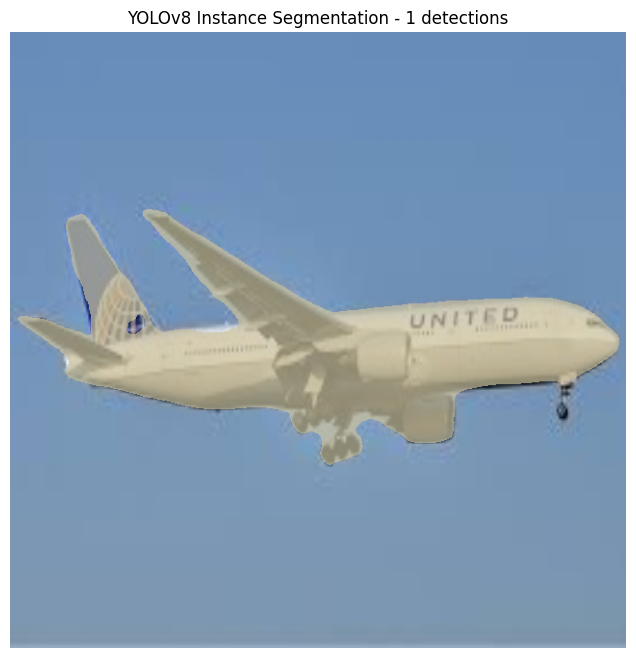


Detection Summary:
  1. airplane: 0.710


In [ ]:
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import os
# from typing import Tuple, Optional

# class YOLOv8SegmentationPostProcessor:
#     def __init__(self, 
#                  conf_threshold: float = 0.5, 
#                  nms_threshold: float = 0.4,
#                  input_size: Tuple[int, int] = (640, 640)):
#         self.conf_threshold = conf_threshold
#         self.nms_threshold = nms_threshold
#         self.input_size = input_size
        
#         self.class_names = [
#             'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
#             'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
#             'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
#             'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
#             'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
#             'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
#             'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
#             'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
#             'hair drier', 'toothbrush'
#         ]
        
#     def load_raw_outputs(self, output0_path: str, output1_path: str) -> Tuple[np.ndarray, np.ndarray]:
#         output0 = np.fromfile(output0_path, dtype=np.float32).reshape(1, 116, 8400)
#         output1 = np.fromfile(output1_path, dtype=np.float32).reshape(1, 160, 160, 32)
#         return output0, output1

#     def decode_predictions(self, output0: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
#         predictions = output0[0]  # [116, 8400]
#         boxes = predictions[:4, :]
#         scores = predictions[4:84, :]
#         mask_coeffs = predictions[84:, :]

#         x_center, y_center, width, height = boxes
#         x1 = x_center - width / 2
#         y1 = y_center - height / 2
#         x2 = x_center + width / 2
#         y2 = y_center + height / 2
#         boxes_xyxy = np.stack([x1, y1, x2, y2], axis=0)

#         return boxes_xyxy, scores, mask_coeffs

#     def filter_predictions(self, boxes, scores, mask_coeffs):
#         max_scores = np.max(scores, axis=0)
#         max_classes = np.argmax(scores, axis=0)
#         valid_mask = max_scores > self.conf_threshold
        
#         print(f"Max score in predictions: {np.max(scores)}")
#         print(f"Number of predictions above threshold: {np.sum(valid_mask)}")
#         print(f"Confidence threshold: {self.conf_threshold}")

#         return (
#             boxes[:, valid_mask],
#             max_scores[valid_mask],
#             max_classes[valid_mask],
#             mask_coeffs[:, valid_mask]
#         )

#     def apply_nms(self, boxes, scores, classes, mask_coeffs):
#         if len(scores) == 0:
#             return boxes, scores, classes, mask_coeffs

#         boxes_xywh = np.stack([
#             boxes[0],
#             boxes[1],
#             boxes[2] - boxes[0],
#             boxes[3] - boxes[1]
#         ], axis=1)

#         indices = cv2.dnn.NMSBoxes(
#             bboxes=boxes_xywh.tolist(),
#             scores=scores.tolist(),
#             score_threshold=self.conf_threshold,
#             nms_threshold=self.nms_threshold
#         )

#         if len(indices) > 0:
#             indices = indices.flatten()
#             print(f"Detections after NMS: {len(indices)}")
#             return (
#                 boxes[:, indices],
#                 scores[indices],
#                 classes[indices],
#                 mask_coeffs[:, indices]
#             )
#         else:
#             print("No detections survived NMS")
#             return (
#                 np.empty((4, 0)),
#                 np.empty((0,)),
#                 np.empty((0,)),
#                 np.empty((32, 0))
#             )

#     def generate_masks(self, mask_coeffs, proto_masks):
#         if mask_coeffs.shape[1] == 0:
#             return np.empty((0, 160, 160))
#         proto_masks = proto_masks[0]  # [160, 160, 32]
#         masks = np.einsum("hwd,dn->hwn", proto_masks, mask_coeffs)
#         masks = 1 / (1 + np.exp(-masks))  # sigmoid
#         masks = masks.transpose(2, 0, 1)  # [N, H, W]
#         print(f"Generated {masks.shape[0]} masks")
#         return masks



#     def scale_coordinates(self, boxes: np.ndarray, original_shape: Tuple[int, int]) -> np.ndarray:
#         orig_h, orig_w = original_shape
#         input_w, input_h = self.input_size

#         gain = min(input_w / orig_w, input_h / orig_h)
#         pad_w = (input_w - orig_w * gain) / 2
#         pad_h = (input_h - orig_h * gain) / 2

#         boxes_scaled = boxes.copy()
#         boxes_scaled[[0, 2]] -= pad_w
#         boxes_scaled[[1, 3]] -= pad_h
#         boxes_scaled /= gain

#         boxes_scaled[0::2] = boxes_scaled[0::2].clip(0, orig_w)
#         boxes_scaled[1::2] = boxes_scaled[1::2].clip(0, orig_h)

#         return boxes_scaled

#     def resize_masks(self, masks, original_shape):
#         if masks.shape[0] == 0:
#             return np.empty((0, original_shape[0], original_shape[1]))

#         orig_h, orig_w = original_shape
#         resized_masks = [cv2.resize(mask, (orig_w, orig_h), interpolation=cv2.INTER_LINEAR) for mask in masks]
#         print(f"Resized {len(resized_masks)} masks to {original_shape}")
#         return np.array(resized_masks)

#     def clean_masks(self, masks):
#         """Minimal mask cleaning - just apply sigmoid threshold"""
#         if masks.shape[0] == 0:
#             return masks
            
#         # Simple threshold - no morphological operations
#         cleaned_masks = (masks > 0.5).astype(np.float32)
#         print(f"Applied threshold to {len(cleaned_masks)} masks")
#         return cleaned_masks

#     def process(self, output0_path: str, output1_path: str, original_image: np.ndarray) -> dict:
#         output0, output1 = self.load_raw_outputs(output0_path, output1_path)
#         boxes, scores, mask_coeffs = self.decode_predictions(output0)

#         boxes, scores, classes, mask_coeffs = self.filter_predictions(boxes, scores, mask_coeffs)
#         boxes, scores, classes, mask_coeffs = self.apply_nms(boxes, scores, classes, mask_coeffs)

#         masks = self.generate_masks(mask_coeffs, output1)

#         # No mask filtering - keep all generated masks
#         print(f"Keeping all {masks.shape[0]} generated masks")

#         orig_shape = original_image.shape[:2]
#         boxes_scaled = self.scale_coordinates(boxes, orig_shape)
#         resized_masks = self.resize_masks(masks, orig_shape)
        
#         # Minimal mask cleaning
#         if resized_masks.shape[0] > 0:
#             resized_masks = self.clean_masks(resized_masks)

#         return {
#             'boxes': boxes_scaled,
#             'scores': scores,
#             'classes': classes,
#             'masks': resized_masks,
#             'class_names': [self.class_names[int(cls)] for cls in classes]
#         }

#     def visualize_results(self, image: np.ndarray, results: dict, save_path: Optional[str] = None,
#                         alpha: float = 0.7, mask_threshold: float = 0.5):
#         """
#         Visualize instance segmentation masks with colors over original image.
#         """
#         image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         overlay = image_rgb.copy()

#         num_instances = len(results['masks'])
#         if num_instances == 0:
#             print("No valid detections found")
#             return

#         print(f"Visualizing {num_instances} detections")

#         # Generate colors for each instance
#         np.random.seed(42)
#         colors = [np.random.randint(100, 256, size=3, dtype=np.uint8) for _ in range(num_instances)]

#         for i, (mask, color) in enumerate(zip(results['masks'], colors)):
#             mask_binary = (mask > mask_threshold).astype(np.uint8)
#             mask_area = np.sum(mask_binary)
            
#             print(f"Mask {i}: area={mask_area}, max_value={np.max(mask):.3f}")

#             # Create colored mask
#             color_mask = np.zeros_like(image_rgb)
#             for c in range(3):
#                 color_mask[:, :, c] = mask_binary * color[c]

#             # Apply mask to overlay
#             mask_3d = np.stack([mask_binary]*3, axis=-1)
#             overlay = np.where(mask_3d, 
#                             (alpha * color_mask + (1 - alpha) * overlay).astype(np.uint8), 
#                             overlay)

#         # Plot
#         plt.figure(figsize=(12, 8))
#         plt.imshow(overlay)
#         plt.title(f"YOLOv8 Instance Segmentation - {num_instances} detections")
#         plt.axis('off')

#         if save_path:
#             os.makedirs(os.path.dirname(save_path), exist_ok=True)
#             cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
#             print(f"Saved to {save_path}")

#         plt.show()

#         print("\nDetection Summary:")
#         for i, (cls, score) in enumerate(zip(results["class_names"], results["scores"])):
#             print(f"  {i+1}. {cls}: {score:.3f}")

# # Example usage
# def main():
#     # Simple instance segmentation processor
#     processor = YOLOv8SegmentationPostProcessor(conf_threshold=0.5, nms_threshold=0.4)

#     image = cv2.imread("airplane.jpg")
#     if image is None:
#         print("Error: Could not load image 'airplane.jpg'")
#         return
        
#     results = processor.process(
#         output0_path="results1/Result_0/output0.raw",
#         output1_path="results1/Result_0/output1.raw",
#         original_image=image
#     )

#     processor.visualize_results(
#         image,
#         results,
#         save_path="./segmentation_results.jpg"
#     )

# if __name__ == "__main__":
#     main()